In [31]:
import os
import glob
import datetime
import importlib
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable

In [32]:
import models.qp as model # import get_stocks # 1/PBR + GP/A
#import models.ncav as model # NCAV
#import models.super_value as model # PBR + PCR + PER + PSR
#import models.super_quality as model

importlib.reload(model)

<module 'models.qp' from '/Users/seunghun/Documents/Projects/stock-backtesting/backtest-playground/models/qp.py'>

In [33]:
MODEL_NAME = 'qp'
DATA_DIR = 'data/daily/10-1'

In [34]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [35]:
df_account

,start_date,end_date,filepath
0,1999-10-01,2000-10-02,data/daily/10-1/1999-10-01.csv
1,2000-10-02,2001-10-01,data/daily/10-1/2000-10-02.csv
2,2001-10-01,2002-10-01,data/daily/10-1/2001-10-01.csv
3,2002-10-01,2003-10-01,data/daily/10-1/2002-10-01.csv
4,2003-10-01,2004-10-01,data/daily/10-1/2003-10-01.csv
5,2004-10-01,2005-10-03,data/daily/10-1/2004-10-01.csv
6,2005-10-03,2006-10-02,data/daily/10-1/2005-10-03.csv
7,2006-10-02,2007-10-01,data/daily/10-1/2006-10-02.csv
8,2007-10-01,2008-10-01,data/daily/10-1/2007-10-01.csv
9,2008-10-01,2009-10-01,data/daily/10-1/2008-10-01.csv


In [36]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: model.get_stocks(x.filepath, x.start_date, False), axis=1)

1999-10-01 선정 기업 수 30
2000-10-02 선정 기업 수 30
2001-10-01 선정 기업 수 30
2002-10-01 선정 기업 수 30
2003-10-01 선정 기업 수 30
2004-10-01 선정 기업 수 30
2005-10-03 선정 기업 수 30
2006-10-02 선정 기업 수 30
2007-10-01 선정 기업 수 30
2008-10-01 선정 기업 수 30
2009-10-01 선정 기업 수 30
2010-10-01 선정 기업 수 30
2011-10-03 선정 기업 수 30
2012-10-01 선정 기업 수 30
2013-10-01 선정 기업 수 30
2014-10-01 선정 기업 수 30
2015-10-01 선정 기업 수 30
2016-10-03 선정 기업 수 30
2017-10-02 선정 기업 수 30
2018-10-01 선정 기업 수 30


In [37]:
# 백테스트 기간의 가격 정보를 가져온다.
df_price = marcap_data(df_account.iloc[0].start_date, df_account.iloc[len(df_account) - 1].end_date)

In [38]:
# 연도별 / 월별 수익률을 구한다.
df_account['monthly_yield'] = 0.0
df_account['monthly_yield'] = df_account['monthly_yield'].astype('object')
df_account['yearly_yield'] = 0.0
df_account['delisted_stocks'] = 0.0
df_account['delisted_stocks'] = df_account['delisted_stocks'].astype('object')
df_account['year_month'] = 0.0
df_account['year_month'] = df_account['year_month'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        stocks = df_account.iloc[i].stocks

        # 한 해의 가격 정보
        df_yearly_price = df_price[(df_price.index >= start_date) & (df_price.index < end_date)]
        
        # 연도-월
        df_year_month = df_yearly_price.groupby(df_yearly_price.index).agg({'Open': 'max'}).reset_index()
        df_year_month['year_month'] = df_year_month.apply(lambda x: str(x.Date)[:7], axis=1)
        df_year_month = df_year_month.groupby("year_month").agg({'Open': 'first'})

        # 종목별 월별 수익률 저장
        df_monthly_yield = pd.DataFrame()

        # 상폐 종목
        delisted_stocks = []
        
        # 종목별 월별 수익률 구하기
        for stock in stocks:
            df_yearly_stock_price = df_yearly_price[df_yearly_price.Code == stock].reset_index()
            if len(df_yearly_stock_price) == 0:
                df_monthly_yield[stock] = [0] * 12
                continue
                
            # 월별 수익률
            df_monthly_stock = pd.DataFrame(index=df_year_month.index)
            df_monthly_stock['yield'] = 1.0 # 1년 내에 가격 정보가 없는 기간은 거래 정지 기간이라고 보고 수익률을 1.0으로 처리
            
            # 월별로 groupby
            df_yearly_stock_price['year_month'] = df_yearly_stock_price.apply(lambda x: str(x.Date)[:7], axis=1)
            df_monthly_stock_yield = df_yearly_stock_price.groupby("year_month").agg({'Open': 'first', 'Close': 'last'})

            # 월별 수익률 기록하기
            for idx, row in enumerate(df_monthly_stock_yield.iterrows()):
                if idx == len(df_monthly_stock_yield) - 1: # 마지막 월
                    df_monthly_stock.at[row[0], 'yield'] = row[1]['Close'] / row[1]['Open']
                else:
                    df_monthly_stock.at[row[0], 'yield'] = df_monthly_stock_yield.iloc[idx + 1]['Open'] / row[1]['Open']
            
            if df_monthly_stock.index[-1] != df_monthly_stock_yield.index[-1]: # 마지막 월이 서로 다를 때 => 상폐 처리
                # 상폐된 row index 구하기
                row_index = len(df_monthly_stock_yield)
                
                # 상폐된 시점에서부터 수익률을 0.0으로 처리
                for idx, row in enumerate(df_monthly_stock.iterrows()):
                    if idx < row_index:
                        continue
                    df_monthly_stock.at[row[0], 'yield'] = 0.0
                
                # 상폐 종목에 추가
                delisted_stocks.append(stock)
            
            monthly_yield = df_monthly_stock['yield'].cumprod().tolist()
            df_monthly_yield[stock] = monthly_yield
            
        df_monthly_yield['total'] = df_monthly_yield.mean(axis=1) 
        df_monthly_yield['prev_total'] = df_monthly_yield['total'].shift(1)
        df_monthly_yield['prev_total'] = df_monthly_yield['prev_total'].fillna(1.0)
        df_monthly_yield['monthly_yield'] = df_monthly_yield['total'] / df_monthly_yield['prev_total'] - 1.0
        
        # 연도-월
        df_account.at[i, 'year_month'] = df_year_month.index.tolist()
        # 월별 수익률
        df_account.at[i, 'monthly_yield'] = df_monthly_yield['monthly_yield'].tolist()
        # 연도별 수익률
        yearly_yield = df_monthly_yield.iloc[len(df_monthly_yield) - 1]['total']
        df_account.at[i, 'yearly_yield'] = yearly_yield
        # 상폐 종목
        df_account.at[i, 'delisted_stocks'] = delisted_stocks

        print(start_date, end_date, yearly_yield)

1999-10-01 2000-10-02 1.3509278832635343
2000-10-02 2001-10-01 1.2533009784909324
2001-10-01 2002-10-01 1.3305074379069408
2002-10-01 2003-10-01 1.0404243043396462
2003-10-01 2004-10-01 1.3311865102597098
2004-10-01 2005-10-03 2.408502315705527
2005-10-03 2006-10-02 1.1802014378650205
2006-10-02 2007-10-01 2.6272184647423393
2007-10-01 2008-10-01 0.7498399396621255
2008-10-01 2009-10-01 1.3426754185156622
2009-10-01 2010-10-01 1.4602145872919852
2010-10-01 2011-10-03 1.6497970480830633
2011-10-03 2012-10-01 2.4355020154388742
2012-10-01 2013-10-01 1.0878638433770067
2013-10-01 2014-10-01 1.4753248415883287
2014-10-01 2015-10-01 1.6687437463670447
2015-10-01 2016-10-03 1.5551781175970332
2016-10-03 2017-10-02 1.108390957956361
2017-10-02 2018-10-01 1.4981212291393915
2018-10-01 2019-10-01 1.0517033834177005


In [39]:
# CAGR, 자산변화 구하기
df_account['cum_yield'] = df_account['yearly_yield'].cumprod()

df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['cum_yield'], 1/(i+1))
cagr = df_account.iloc[len(df_account) - 1]['cagr']

monthly_yields = []
for i in range(len(df_account)):
    monthly_yields.extend(df_account.iloc[i]['monthly_yield'])
cum_monthly_yield = np.cumprod(np.array(monthly_yields) + 1)

cagr_history = []
for i, val in enumerate(cum_monthly_yield.tolist()):
    year = (i + 1) / 12
    cagr_history.append(pow(val, 1 / year))

# 수익률 표준편차 구하기
filetered_monthly_yield = monthly_yields.copy()

# outlier 제거
filetered_monthly_yield.remove(max(filetered_monthly_yield))
filetered_monthly_yield.remove(min(filetered_monthly_yield))

std_monthly_yield =  statistics.stdev(filetered_monthly_yield)

# 월별 승률
monthly_win_rate = (sum([val > 0 for val in monthly_yields]) / len(monthly_yields)) * 100.0

# 상폐 종목 수
delisted_stocks = []
for row in df_account.iterrows():
    delisted_stocks.extend(row[1]['delisted_stocks'])
    
# 연도-월
year_months = []
for row in df_account.iterrows():
    year_months.extend(row[1]['year_month'])

In [40]:
# MDD, MDD duration 구하기
max_yield = -100.0
min_yield = 0.0
mdd = 0.0
mdd_duration = 0 

dd = 0.0
dd_duration = 0
for val in cum_monthly_yield:
    if val > max_yield:
        max_yield = val
        min_yield = val
        dd_duration = 0
        continue
    
    if val < min_yield:
        min_yield = val
        dd = (1.0 - min_yield / max_yield) * 100.0
        dd_duration += 1
        
        if dd > mdd:
            mdd = dd
        if dd_duration > mdd_duration:
            mdd_duration = dd_duration

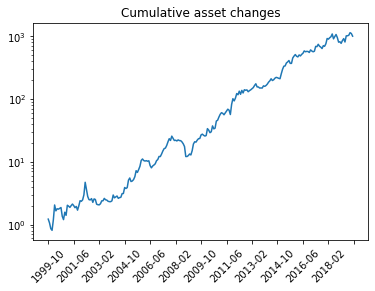

In [41]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(year_months, cum_monthly_yield)

loc = ticker.MultipleLocator(base=20.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xticks(rotation=45)

plt.title('Cumulative asset changes')
plt.show()

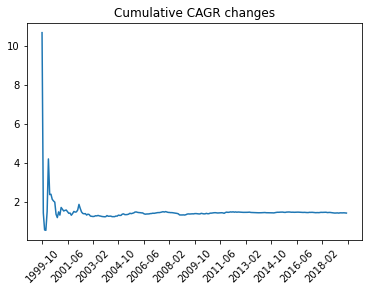

In [42]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
ax.plot(year_months, cagr_history, marker='', linestyle='-')

loc = ticker.MultipleLocator(base=20.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xticks(rotation=45)

plt.title('Cumulative CAGR changes')
plt.show()

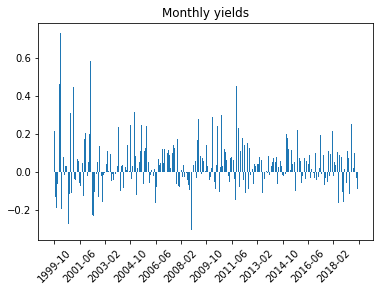

In [43]:
fig, ax = plt.subplots()
plt.bar(year_months, monthly_yields)
loc = ticker.MultipleLocator(base=20.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xticks(rotation=45)
plt.title("Monthly yields")
plt.show()

In [44]:
t = PrettyTable(['Rebalance', 'CAGR', 'MDD', 'MDD duration', 'STD', 'Delisted', 'Win rate', 'Note'])
t.add_row([os.path.basename(DATA_DIR),
           "%.2f%%" % ((cagr - 1.0) * 100.0),
           "%.2f%%" % (mdd),
           mdd_duration,
           "%.4f" % std_monthly_yield,
           len(delisted_stocks),
           "%.2f%%" % monthly_win_rate,
           ""
          ])
print(t)

+-----------+--------+--------+--------------+--------+----------+----------+------+
| Rebalance |  CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Note |
+-----------+--------+--------+--------------+--------+----------+----------+------+
|    10-1   | 41.26% | 56.33% |      8       | 0.1183 |    11    |  59.17%  |      |
+-----------+--------+--------+--------------+--------+----------+----------+------+
